##Importing Libs

In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('Combined_Data.csv')

In [3]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
df.describe()

,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


In [6]:
df["status"].value_counts()

,count
status,
Normal,16351
Depression,15404
Suicidal,10653
Anxiety,3888
Bipolar,2877
Stress,2669
Personality disorder,1201


In [7]:
df.isnull().sum()

,0
statement,362
status,0


In [8]:
df.duplicated().sum()

np.int64(1944)

# Insights
Imbalanced dataset
count-53k
null values - 362
duplicate - 1944

## Data Cleaning

In [9]:
df.dropna(inplace=True)

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.status.value_counts()

,count
status,
Normal,16040
Depression,15094
Suicidal,10644
Anxiety,3623
Bipolar,2501
Stress,2296
Personality disorder,895


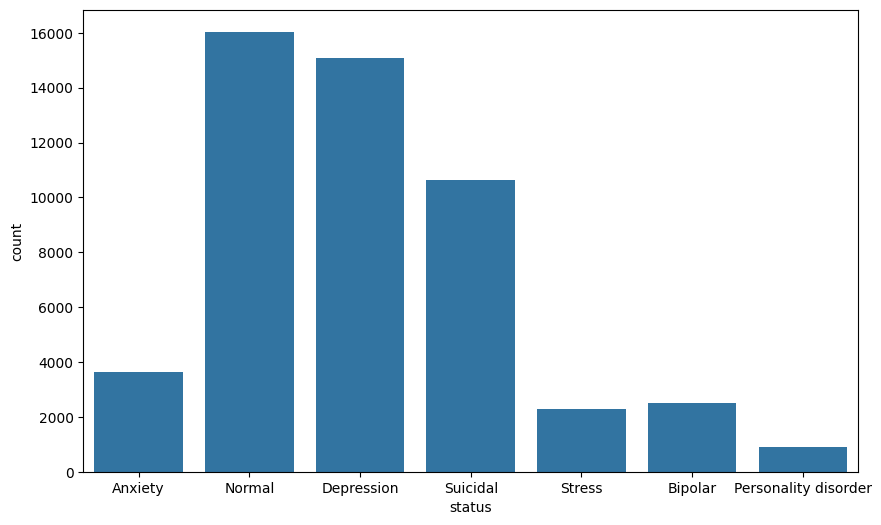

In [12]:
plt.figure(figsize=(10,6))
sns.countplot(x='status',data=df)
plt.show()

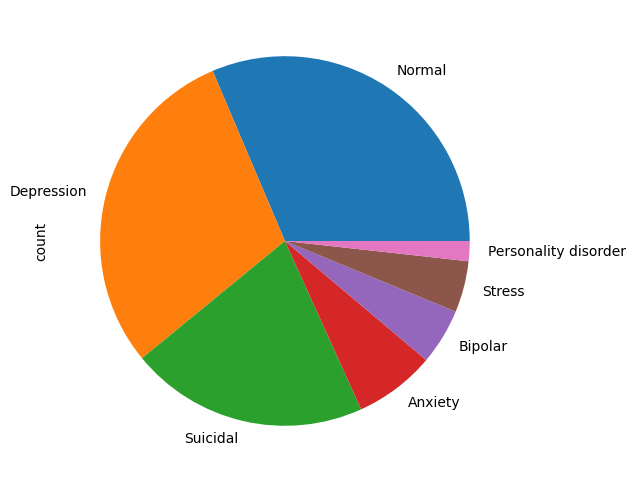

In [13]:
df['status'].value_counts().plot(kind='pie',figsize=(10,6))
plt.show()

## Reducing the size of dataset for faster model training

In [14]:
df=df.sample(n=6000,random_state=42).reset_index(drop=True)
X=df.drop(['status'],axis=1)
y=df.status
sampler=RandomOverSampler(sampling_strategy="auto",random_state=42)
X_resampled,y_resampled=sampler.fit_resample(X,y)
df=pd.concat([X_resampled,y_resampled],axis=1)
df["status"].value_counts()

,count
status,
Suicidal,1905
Stress,1905
Depression,1905
Normal,1905
Anxiety,1905
Personality disorder,1905
Bipolar,1905


In [15]:
no_of_words=df.statement.apply(lambda x:len(x.split()))
no_of_words.head()

,statement
0,11
1,30
2,225
3,66
4,6


In [16]:
no_of_lines=df.statement.apply(lambda x:len(x.split(".")))
no_of_lines.head()

,statement
0,1
1,6
2,14
3,7
4,1


In [17]:
df=pd.concat([df,no_of_words,no_of_lines],axis=1)
df.columns=['statement','status','no_of_words','no_of_lines']
df.head()

,statement,status,no_of_words,no_of_lines
0,I take 100 mg orally How much zoloft is too much?,Suicidal,11,1
1,Sometimes my voice catches for a minute and I ...,Stress,30,6
2,"i am 17f and first of all, my family got issue...",Depression,225,14
3,I already have a plan. Ill wait until late at ...,Suicidal,66,7
4,WHAT DO YOU SAY TO DREAMIES??!!!,Normal,6,1


In [18]:
nltk.download('stopwords')
stop_words=(nltk.corpus.stopwords.words('english'))
nltk.download('punkt_tab')
nltk.download('wordnet')

def cleaning(text):
    preprocessed=text.lower()
    preprocessed=re.sub(r"[^a-zA-Z\s]","",preprocessed)
    words=nltk.word_tokenize(preprocessed)
    filtered_words=[word for word in words if word not in stop_words]
    lemma=WordNetLemmatizer()
    filtered_words=[lemma.lemmatize(word) for word in filtered_words]
    return " ".join(filtered_words)

df.statement=df.statement.apply(cleaning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [19]:
df.describe()

,no_of_words,no_of_lines
count,13335.000000,13335.000000
mean,131.232021,8.316985
std,154.267702,9.766761
min,1.000000,1.000000
25%,37.000000,2.000000
50%,85.000000,6.000000
75%,168.000000,11.000000
max,2599.000000,248.000000


In [20]:
sample=df.drop('statement',axis=1)
sample.head()

,status,no_of_words,no_of_lines
0,Suicidal,11,1
1,Stress,30,6
2,Depression,225,14
3,Suicidal,66,7
4,Normal,6,1


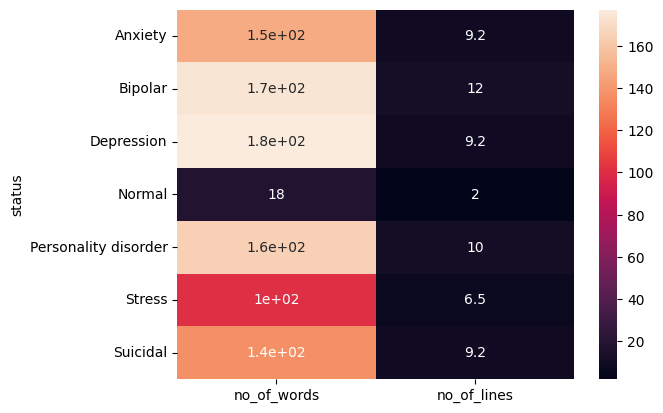

In [21]:
grouped = df.groupby('status')[['no_of_words', 'no_of_lines']].mean()
sns.heatmap(grouped, annot=True,)
plt.show()

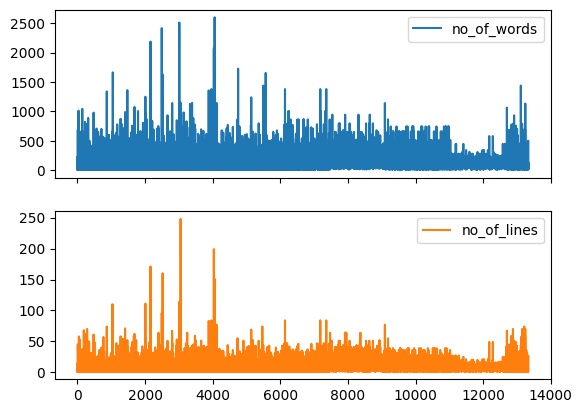

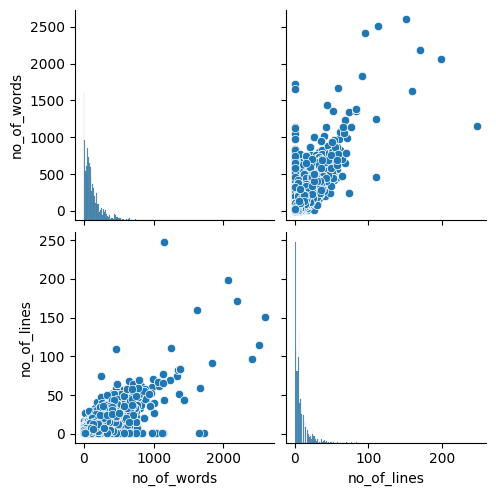

In [22]:
sample.plot(subplots=True)
sns.pairplot(sample)

In [23]:
X=df.statement
y=df.status

In [ ]:
df.to_csv('Preprocessed.csv')

## ML models

In [ ]:
!pip install lightgbm catboost xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.7 MB/s eta 0:00:00


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import (
    LogisticRegression, RidgeClassifier, SGDClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    BaggingClassifier, ExtraTreesClassifier, StackingClassifier, VotingClassifier
)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [25]:
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Ridge Classifier", RidgeClassifier()),
    ("SGD Classifier", SGDClassifier()),

    ("KNearest Neighbour", KNeighborsClassifier()),
    ("Decision Tree", DecisionTreeClassifier(max_depth=135)),

    ("Random Forest", RandomForestClassifier()),
    ("Extra Trees", ExtraTreesClassifier()),
    ("Bagging", BaggingClassifier()),

    ("Gaussian NB", GaussianNB()),
    ("BernoulliNB",BernoulliNB()),

    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)),
    ("LightGBM", LGBMClassifier()),
]

In [26]:
le = LabelEncoder()
y = le.fit_transform(y)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [27]:
bow=CountVectorizer(max_features=3000,ngram_range=(1,3))
X_train_bow=bow.fit_transform(X_train)
X_test_bow=bow.transform(X_test)
tfidf=TfidfVectorizer(max_features=3000,ngram_range=(1,3))
X_train_tfidf=tfidf.fit_transform(X_train)
X_test_tfidf=tfidf.transform(X_test)

In [28]:
def class_model_train(name, model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)


    y_pred_test = model.predict(x_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    prec_test = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
    rec_test = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)
    f1_test = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)

    print(f"\n---------- {name} (Test) ----------")
    print("Accuracy :", acc_test)
    print("Precision:", prec_test)
    print("Recall   :", rec_test)
    print("F1 Score :", f1_test)

    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))


    y_pred_train = model.predict(x_train)
    acc_train = accuracy_score(y_train, y_pred_train)
    prec_train = precision_score(y_train, y_pred_train, average='weighted', zero_division=0)
    rec_train = recall_score(y_train, y_pred_train, average='weighted', zero_division=0)
    f1_train = f1_score(y_train, y_pred_train, average='weighted', zero_division=0)

    print(f"\n---------- {name} (Train) ----------")
    print("Accuracy :", acc_train)
    print("Precision:", prec_train)
    print("Recall   :", rec_train)
    print("F1 Score :", f1_train)
    print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred_train))

    return acc_test,name

In [ ]:
res_bow=[class_model_train(name, model, X_train_bow.toarray(), y_train, X_test_bow.toarray(), y_test) for name, model in models]
res_bow=pd.DataFrame(res_bow,columns=['Accuracy','Model'])
res_bow.sort_values(by='Accuracy',ascending=False)


---------- Logistic Regression (Test) ----------
Accuracy : 0.9034559643255295
Precision: 0.900350999996363
Recall   : 0.9034559643255295
F1 Score : 0.9010938530852749
Confusion Matrix:
 [[619   2   2   4   0   0   4]
 [  0 630   0   0   0   0   0]
 [ 14   7 419  26   7  18 137]
 [  6   2  10 578   4  18  15]
 [  0   0   0   0 630   0   0]
 [  0   0   0   5   0 634   0]
 [  1   1 104  43   1   2 542]]

---------- Logistic Regression (Train) ----------
Accuracy : 0.9805976806422837
Precision: 0.9808742353594234
Recall   : 0.9805976806422837
F1 Score : 0.9805633480998371
Confusion Matrix:
 [[2551    0    0   20    0    0    1]
 [   0 2572    0    1    0    0    0]
 [   3    0 2405   47    0    2  118]
 [   4    0    2 2557    0    0    7]
 [   0    0    0    0 2573    0    0]
 [   0    0    0    5    0 2559    0]
 [   0    0   55   83    0    0 2371]]

---------- Ridge Classifier (Test) ----------
Accuracy : 0.8347826086956521
Precision: 0.8372627196330404
Recall   : 0.8347826086956521


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



---------- LightGBM (Test) ----------
Accuracy : 0.9121516164994425
Precision: 0.9104688337032076
Recall   : 0.9121516164994425
F1 Score : 0.9103201568157337
Confusion Matrix:
 [[622   3   0   4   0   1   1]
 [  0 630   0   0   0   0   0]
 [  9   3 440  24   2  19 131]
 [  6   1  11 575   0  23  17]
 [  0   0   0   0 630   0   0]
 [  0   0   0   5   0 634   0]
 [  1   4  78  47   0   4 560]]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



---------- LightGBM (Train) ----------
Accuracy : 0.9745762711864406
Precision: 0.975043051537063
Recall   : 0.9745762711864406
F1 Score : 0.9744885198091884
Confusion Matrix:
 [[2557    0    0   14    0    0    1]
 [   0 2573    0    0    0    0    0]
 [   5    0 2330   54    0    2  184]
 [   4    0    5 2548    0    3   10]
 [   0    0    0    0 2573    0    0]
 [   0    0    0    5    0 2559    0]
 [   1    0   55  112    0    1 2340]]


,Accuracy,Model
6,0.918618,Extra Trees
5,0.914827,Random Forest
11,0.912152,LightGBM
0,0.903456,Logistic Regression
10,0.898551,XGBoost
2,0.894983,SGD Classifier
7,0.886957,Bagging
4,0.879822,Decision Tree
1,0.834783,Ridge Classifier
3,0.755407,KNearest Neighbour


In [ ]:
res_tfidf=[class_model_train(name, model, X_train_tfidf.toarray(), y_train, X_test_tfidf.toarray(), y_test) for name, model in models]
res_tfidf=pd.DataFrame(res_tfidf,columns=['Accuracy','Model'])
res_tfidf.sort_values(by='Accuracy',ascending=False)


---------- Logistic Regression (Test) ----------
Accuracy : 0.8726867335562988
Precision: 0.8690034674109747
Recall   : 0.8726867335562988
F1 Score : 0.8696307701330548
Confusion Matrix:
 [[593   6   7   7   3  13   2]
 [  1 610   6   6   2   4   1]
 [ 14   8 386  41  13  19 147]
 [  7   4  12 567   2  30  11]
 [  0   0   0   0 630   0   0]
 [ 16   1   0   7   3 608   4]
 [  1   2 108  53   4   6 520]]

---------- Logistic Regression (Train) ----------
Accuracy : 0.9199933095450491
Precision: 0.9189863079659343
Recall   : 0.9199933095450491
F1 Score : 0.9187548664070325
Confusion Matrix:
 [[2487   13   20   23    6   17    6]
 [   5 2532    9   17    3    3    4]
 [  45   27 1918   91   28   49  417]
 [  15    7   25 2396   11   78   38]
 [   0    0    0    0 2573    0    0]
 [  29    4    4   12    7 2498   10]
 [   4    4  252  137    6    9 2097]]

---------- Ridge Classifier (Test) ----------
Accuracy : 0.8613154960981048
Precision: 0.8562605116071953
Recall   : 0.8613154960981048

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



---------- LightGBM (Test) ----------
Accuracy : 0.9157190635451505
Precision: 0.9138733860677668
Recall   : 0.9157190635451505
F1 Score : 0.9142130954741843
Confusion Matrix:
 [[625   3   2   0   0   1   0]
 [  0 630   0   0   0   0   0]
 [  6   2 449  26   1  19 125]
 [  4   1  20 570   0  22  16]
 [  0   0   0   0 630   0   0]
 [  0   0   0   0   0 639   0]
 [  1   2  83  43   0   1 564]]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



---------- LightGBM (Train) ----------
Accuracy : 0.9903545941123997
Precision: 0.9905122685026324
Recall   : 0.9903545941123997
F1 Score : 0.9903451924398622
Confusion Matrix:
 [[2570    0    1    1    0    0    0]
 [   0 2573    0    0    0    0    0]
 [   1    0 2475   41    0    0   58]
 [   3    0    1 2566    0    0    0]
 [   0    0    0    0 2573    0    0]
 [   0    0    0    0    0 2564    0]
 [   0    0   10   56    0    1 2442]]


,Accuracy,Model
5,0.922408,Random Forest
6,0.920178,Extra Trees
11,0.915719,LightGBM
10,0.900780,XGBoost
7,0.893200,Bagging
4,0.886065,Decision Tree
0,0.872687,Logistic Regression
2,0.868673,SGD Classifier
1,0.861315,Ridge Classifier
8,0.741360,Gaussian NB


## Hyper Parameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

model = ExtraTreesClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

random_search1 = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=3,n_jobs=-1, scoring='accuracy',
    verbose=2,random_state=42)

random_search1.fit(X_train_bow, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=ExtraTreesClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [20, 30, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='accuracy', verbose=2)

In [ ]:
random_search1.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'criterion': 'gini'}

In [ ]:

random_search1.best_score_

np.float64(0.8658893468182439)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

model = ExtraTreesClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

random_search2 = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=3,n_jobs=-1, scoring='accuracy',
    verbose=2,random_state=42)

random_search2.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=ExtraTreesClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [20, 30, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='accuracy', verbose=2)

In [ ]:
random_search2.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'criterion': 'gini'}

In [ ]:

random_search2.best_score_

np.float64(0.8754537192807755)

In [ ]:
ex_bow=ExtraTreesClassifier(n_estimators=100 ,criterion='gini' ,max_depth=50 ,min_samples_split=2 ,min_samples_leaf=1 ,max_features='sqrt' ,random_state=42)
ex_tfidf=ExtraTreesClassifier(n_estimators=100 ,criterion='gini' ,max_depth=50 ,min_samples_split=2 ,min_samples_leaf=1 ,max_features='sqrt' ,random_state=42)

In [ ]:
class_model_train("ex_bow", ex_bow, X_train_bow, y_train, X_test_bow, y_test)
class_model_train("ex_tfidf", ex_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test)


---------- ex_bow (Test) ----------
Accuracy : 0.8789297658862876
Precision: 0.8896195905614156
Recall   : 0.8789297658862876
F1 Score : 0.8792776334375229
Confusion Matrix:
 [[582   0   7  42   0   0   0]
 [  0 617   0  13   0   0   0]
 [ 12   3 440  83   0   0  90]
 [  1   0  15 607   0   4   6]
 [  0   0   0  13 617   0   0]
 [  0   0   0  25   0 614   0]
 [  0   1 118 110   0   0 465]]

---------- ex_bow (Train) ----------
Accuracy : 0.9418487957181089
Precision: 0.957445014065113
Recall   : 0.9418487957181089
F1 Score : 0.9448847337275526
Confusion Matrix:
 [[2398    0    1  173    0    0    0]
 [   0 2539    0   34    0    0    0]
 [   0    0 2283  262    0    0   30]
 [   0    0    0 2570    0    0    0]
 [   0    0    0   88 2485    0    0]
 [   0    0    0   77    0 2487    0]
 [   0    0    2  376    0    0 2131]]

---------- ex_tfidf (Test) ----------
Accuracy : 0.8947603121516166
Precision: 0.9004059659296932
Recall   : 0.8947603121516166
F1 Score : 0.8942829955023277
Conf

(0.8947603121516166, 'ex_tfidf')

## model params Testing for better accuracy

In [ ]:
ex_def=ExtraTreesClassifier(n_estimators=300,criterion='gini' ,random_state=42)
class_model_train("ex_def", ex_def, X_train_bow, y_train, X_test_bow, y_test)


---------- ex_def (Test) ----------
Accuracy : 0.9212931995540691
Precision: 0.9229884352568148
Recall   : 0.9212931995540691
F1 Score : 0.9203724498872232
Confusion Matrix:
 [[622   0   6   3   0   0   0]
 [  0 630   0   0   0   0   0]
 [  8   1 514  41   0   1  63]
 [  2   0  22 601   0   0   8]
 [  0   0   0   0 630   0   0]
 [  0   0   0   0   0 639   0]
 [  0   1 143  54   0   0 496]]

---------- ex_def (Train) ----------
Accuracy : 0.9992194469223907
Precision: 0.9992202482637768
Recall   : 0.9992194469223907
F1 Score : 0.9992194398417767
Confusion Matrix:
 [[2572    0    0    0    0    0    0]
 [   0 2573    0    0    0    0    0]
 [   1    0 2572    2    0    0    0]
 [   3    0    1 2566    0    0    0]
 [   0    0    0    0 2573    0    0]
 [   0    0    0    0    0 2564    0]
 [   0    0    2    5    0    0 2502]]


(0.9212931995540691, 'ex_def')

In [ ]:
rf_def=RandomForestClassifier(n_estimators=300,criterion='gini' ,random_state=42)
class_model_train("rf_def", rf_def, X_train_bow, y_train, X_test_bow, y_test)


---------- rf_def (Test) ----------
Accuracy : 0.9201783723522854
Precision: 0.9186228805823325
Recall   : 0.9201783723522854
F1 Score : 0.9186894406380725
Confusion Matrix:
 [[625   3   2   1   0   0   0]
 [  0 630   0   0   0   0   0]
 [ 11   4 470  44   1   6  92]
 [  5   0  12 598   0   6  12]
 [  0   0   0   0 630   0   0]
 [  0   0   0   0   0 639   0]
 [  0   1 100  58   0   0 535]]

---------- rf_def (Train) ----------
Accuracy : 0.9992194469223907
Precision: 0.9992200928368238
Recall   : 0.9992194469223907
F1 Score : 0.9992195632122621
Confusion Matrix:
 [[2570    0    1    1    0    0    0]
 [   0 2573    0    0    0    0    0]
 [   0    0 2571    2    0    0    2]
 [   2    0    1 2567    0    0    0]
 [   0    0    0    0 2573    0    0]
 [   0    0    0    0    0 2564    0]
 [   0    0    0    5    0    0 2504]]


(0.9201783723522854, 'rf_def')

In [ ]:
ex_def_1=ExtraTreesClassifier(n_estimators=300,criterion='gini' ,random_state=42)
class_model_train("ex_def_1", ex_def_1, X_train_tfidf, y_train, X_test_tfidf, y_test)


---------- ex_def_1 (Test) ----------
Accuracy : 0.9272590926134233
Precision: 0.9267428213370065
Recall   : 0.9272590926134233
F1 Score : 0.9261956408059299
Confusion Matrix:
 [[378   0   0   2   0   0   0]
 [  0 397   0   0   0   0   0]
 [  3   1 308  20   0   0  51]
 [  0   0  10 348   0   1   5]
 [  0   0   0   0 394   0   0]
 [  0   0   0   0   0 363   0]
 [  0   0  65  36   0   0 285]]

---------- ex_def_1 (Train) ----------
Accuracy : 0.9996250468691413
Precision: 0.9996252924180156
Recall   : 0.9996250468691413
F1 Score : 0.9996250774615959
Confusion Matrix:
 [[1525    0    0    0    0    0    0]
 [   0 1508    0    0    0    0    0]
 [   0    0 1521    1    0    0    0]
 [   2    0    0 1539    0    0    0]
 [   0    0    0    0 1511    0    0]
 [   0    0    0    0    0 1542    0]
 [   0    0    0    1    0    0 1518]]


(0.9272590926134233, 'ex_def_1')

In [29]:
ex_def_1=ExtraTreesClassifier(n_estimators=80,criterion='gini' ,random_state=42)
class_model_train("ex_def_1", ex_def_1, X_train_tfidf, y_train, X_test_tfidf, y_test)


---------- ex_def_1 (Test) ----------
Accuracy : 0.922384701912261
Precision: 0.9218431349906882
Recall   : 0.922384701912261
F1 Score : 0.9212259822060374
Confusion Matrix:
 [[375   0   3   2   0   0   0]
 [  0 397   0   0   0   0   0]
 [  4   0 306  20   0   0  53]
 [  0   0   9 348   0   0   7]
 [  0   0   0   0 394   0   0]
 [  0   0   0   0   0 363   0]
 [  0   2  71  36   0   0 277]]

---------- ex_def_1 (Train) ----------
Accuracy : 0.9996250468691413
Precision: 0.9996252924180156
Recall   : 0.9996250468691413
F1 Score : 0.9996250774615959
Confusion Matrix:
 [[1525    0    0    0    0    0    0]
 [   0 1508    0    0    0    0    0]
 [   0    0 1521    1    0    0    0]
 [   2    0    0 1539    0    0    0]
 [   0    0    0    0 1511    0    0]
 [   0    0    0    0    0 1542    0]
 [   0    0    0    1    0    0 1518]]


(0.922384701912261, 'ex_def_1')

In [ ]:
rf_def_1=RandomForestClassifier(n_estimators=300,criterion='gini' ,random_state=42)
class_model_train("rf_def_1", rf_def_1, X_train_tfidf, y_train, X_test_tfidf, y_test)


---------- rf_def_1 (Test) ----------
Accuracy : 0.9157190635451505
Precision: 0.9138241273557145
Recall   : 0.9157190635451505
F1 Score : 0.9144604755230736
Confusion Matrix:
 [[624   3   1   1   0   2   0]
 [  0 630   0   0   0   0   0]
 [  8   4 469  34   1   8 104]
 [  4   1  21 579   0  12  16]
 [  0   0   0   0 630   0   0]
 [  0   0   0   0   0 639   0]
 [  0   1 104  53   0   0 536]]

---------- rf_def_1 (Train) ----------
Accuracy : 0.999163693131133
Precision: 0.9991645971517966
Recall   : 0.999163693131133
F1 Score : 0.9991638402742334
Confusion Matrix:
 [[2570    0    1    1    0    0    0]
 [   0 2573    0    0    0    0    0]
 [   0    0 2571    2    0    0    2]
 [   2    0    1 2567    0    0    0]
 [   0    0    0    0 2573    0    0]
 [   0    0    0    0    0 2564    0]
 [   0    0    0    6    0    0 2503]]


(0.9157190635451505, 'rf_def_1')

In [ ]:
decision_tree=DecisionTreeClassifier(max_depth=120)
class_model_train("decision_tree", decision_tree, X_train_tfidf, y_train, X_test_tfidf, y_test)


---------- decision_tree (Test) ----------
Accuracy : 0.8836120401337793
Precision: 0.8790952606303581
Recall   : 0.8836120401337793
F1 Score : 0.8805398142899259
Confusion Matrix:
 [[622   4   2   0   0   3   0]
 [  0 630   0   0   0   0   0]
 [ 16  12 400  34   6  24 136]
 [ 10  10  32 522   6  20  33]
 [  0   0   0   0 630   0   0]
 [  0   0   0   0   0 639   0]
 [  1   5 117  45   2   4 520]]

---------- decision_tree (Train) ----------
Accuracy : 0.9966547725245317
Precision: 0.9967095555611597
Recall   : 0.9966547725245317
F1 Score : 0.9966595635939152
Confusion Matrix:
 [[2572    0    0    0    0    0    0]
 [   0 2573    0    0    0    0    0]
 [   1    0 2559   15    0    0    0]
 [   3    0    1 2566    0    0    0]
 [   0    0    0    0 2573    0    0]
 [   0    0    0    0    0 2564    0]
 [   0    0    2   38    0    0 2469]]


(0.8836120401337793, 'decision_tree')

##Model Saving

In [ ]:
print(le.classes_)

['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']


In [ ]:
import pickle
pickle.dump(ex_def_1,open('model.pkl','wb'))
pickle.dump(tfidf,open('tfidf.pkl','wb'))
pickle.dump(le,open('encoder.pkl','wb'))
pickle.dump(cleaned,open('cleaned.pkl','wb'))

## Model_Used-ExtraTreesClassifier

----------(Testing) ----------                                           

Accuracy : 92.42 %                                                               
Precision: 92.39 %                                                               
Recall   : 92.42 %                                                               
F1 Score : 92.32 %                                                               

----------(Validation) ----------                                                  
Accuracy : 99.96 %                                                               
Precision: 99.96 %                                                               
Recall   : 99.96 %                                                               
F1 Score : 99.96 %


In [30]:
y_pred=ex_def_1.predict(X_test_tfidf)
print(confusion_matrix(y_test,y_pred))
y_pred_proba = ex_def_1.predict_proba(X_test_tfidf)
loss = log_loss(y_test, y_pred_proba)
print("Log Loss:", loss)

[[375   0   3   2   0   0   0]
 [  0 397   0   0   0   0   0]
 [  4   0 306  20   0   0  53]
 [  0   0   9 348   0   0   7]
 [  0   0   0   0 394   0   0]
 [  0   0   0   0   0 363   0]
 [  0   2  71  36   0   0 277]]
Log Loss: 0.2442133215432278


## Graphs

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import cycle
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

In [35]:
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)
classes = le.classes_

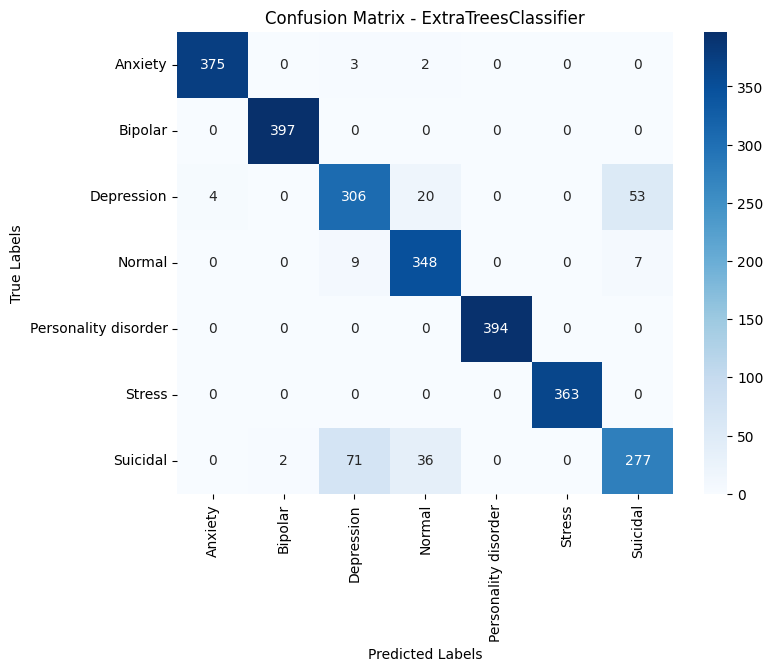

In [36]:
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - ExtraTreesClassifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

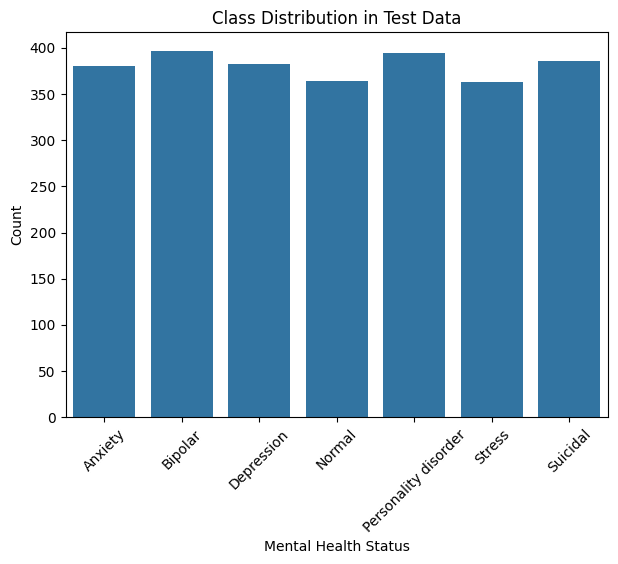

In [37]:
plt.figure(figsize=(7,5))
sns.countplot(x=y_test_labels, order=classes)
plt.title('Class Distribution in Test Data')
plt.xlabel('Mental Health Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

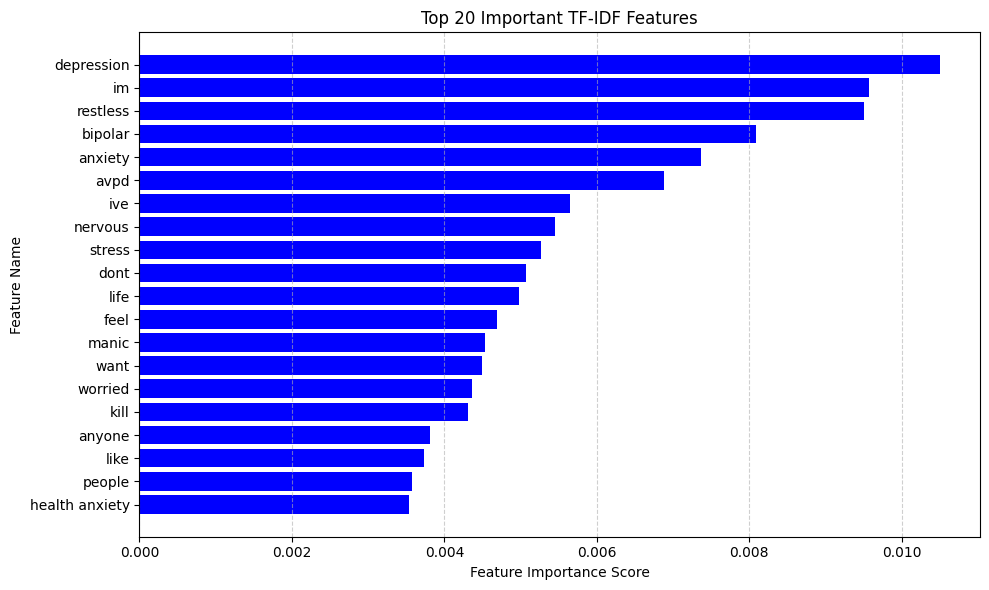

In [51]:
feature_names = tfidf.get_feature_names_out()
importances = ex_def_1.feature_importances_
indices = np.argsort(importances)[-20:]
top_features = feature_names[indices]
top_importances = importances[indices]
plt.figure(figsize=(10,6))
plt.barh(top_features, top_importances, color='blue')
plt.title('Top 20 Important TF-IDF Features')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature Name')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


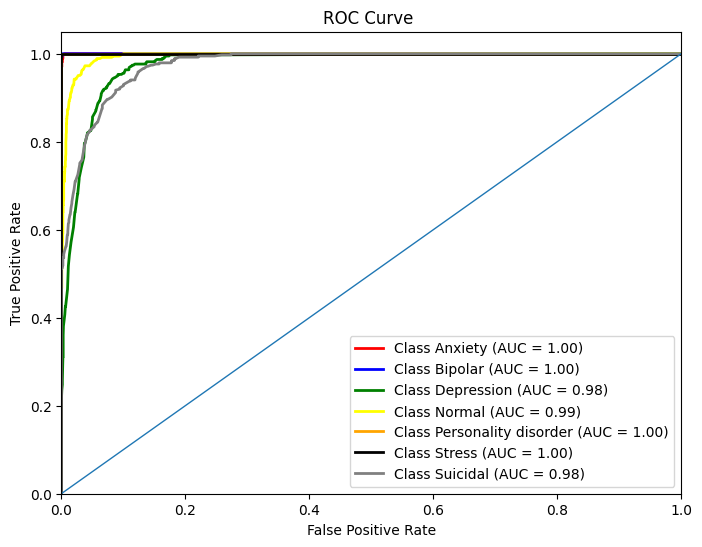

In [42]:
y_test_bin = label_binarize(y_test, classes=range(len(classes)))
n_classes = y_test_bin.shape[1]

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
colors = cycle(['red', 'blue', 'green', 'yellow', 'orange', 'black','gray'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve ')
plt.legend(loc="lower right")
plt.show()

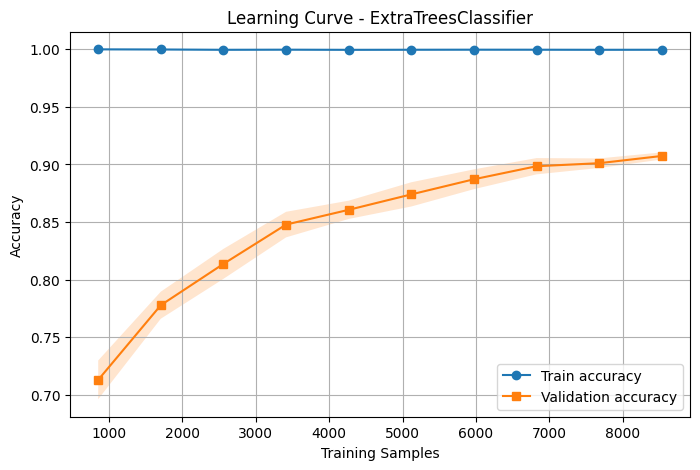

In [ ]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=ExtraTreesClassifier(n_estimators=80, criterion='gini', random_state=42),
    X=X_train_tfidf,
    y=y_train,
    train_sizes=train_sizes,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
valid_mean = valid_scores.mean(axis=1)
valid_std = valid_scores.std(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, marker='o', label='Train accuracy')
plt.plot(train_sizes, valid_mean, marker='s', label='Validation accuracy')

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(train_sizes, valid_mean-valid_std, valid_mean+valid_std, alpha=0.2)

plt.title('Learning Curve - ExtraTreesClassifier')
plt.xlabel('Training Samples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
